### Pulling from Mongo and Pandas


In [1]:
import pymongo
from redis import Redis

redis_connection = Redis(host='this_redis')
mongo_client = pymongo.MongoClient('this_mongo')


In [2]:
mongo_client.database_names()

['admin', 'config', 'local']

In [3]:
import pandas as pd

In [4]:
twentyktweets = pd.read_pickle('../data/twentyktweets.p')

In [5]:
mongo_client.twitter.tweets.insert_many(twentyktweets.to_dict('records'))

In [6]:
tweet_sample = twentyktweets.sample(20).to_dict('records')

In [7]:
mongo_client.twitter.tweets_sample.insert_many(tweet_sample)

In [9]:
cur = (mongo_client
       .twitter
       .tweets_sample
       .find(projection={'_id': 0, 'text' : 1}))

In [14]:
next(cur)['text']

'@DavidAlvareeezy @TimothyDeLaG I’ve heard back in the day record labels would tell their new artists that if they g… https://t.co/acM0pke3xX'

### Parallel MapReduce

In [16]:
cd ..

/home/jovyan


In [17]:
from redis import Redis 
from rq import Queue
from lib.worker import remove_punctuation, mapper, reducer, toggle_hold, check_hold
import time
redis_connection = Redis('this_redis')
job_queue = Queue(connection=redis_connection)

Here is our previous implementation of the `word_count` function.

    def word_count(documents, redis_connection, word_list='word_list'):

        counts = []

        for document in documents:
            mapper(document, redis_connection, word_list)

        word = redis_connection.spop(word_list)
        while word:
            word = word.decode()
            count = reducer(word, redis_connection)
            counts.append((word, count))
            word = redis_connection.spop(word_list)

        return counts
        
There are two candidates for parallelization in this function:

1. the `for` loop can be parallelized as tokenization of one document is completely independent of the tokenization of another.
1. the `while` loop can be parallelized as the counting of tokens for one word is completely independent of the counting of another.

There was one tricky aspect to this parallelization, however. We cannot work on the word counts until all of the tokenization is complete.

In [18]:
def map_documents_mongo(cursor):
    for document in cursor:
        job = job_queue.enqueue(mapper, 
                                document['text'], 
                                'word_list')
    return job

In [19]:
def reduce_words():

    word = redis_connection.spop('word_list')
    while word:
        word = word.decode()
        job = job_queue.enqueue(reducer, word, 'count_list')
        word = redis_connection.spop('word_list')
    
    return job

In [20]:
def collect_counts():
    
    counts = []
    count = redis_connection.lpop('count_list')
    while count:
        counts.append(count)
        count = redis_connection.lpop('count_list')
        
        
    counts = [remove_punctuation(count.decode())
              for count in counts]
    counts = [count.split()
              for count in counts]
    counts = [(count[0], int(count[1]))
              for count in counts]
    return counts

In [21]:
cur = (mongo_client
       .twitter
       .tweets_sample
       .find(projection={'_id': 0, 'text' : 1}))
job = map_documents_mongo(cur)

print("Mapping Documents.")
status = job.status
while status != 'finished':
    print(".", end="")
    status = job.status
    time.sleep(0.1)

job = reduce_words()

print("\nReducing Word Tokens.")
status = job.status
while status != 'finished':
    print(".", end="")
    status = job.status
    time.sleep(0.1)

results = pd.DataFrame(collect_counts(), columns=['word', 'count'])

results.sort_values('count', ascending=False).head(10)

Mapping Documents.
.........................................
Reducing Word Tokens.
.........................................................................................................................................................................................................................................................

,word,count
109,the,5
102,that,5
74,in,4
85,i,4
53,was,3
67,new,3
87,go,2
131,they,2
44,a,2
138,their,2


In [22]:
def map_documents_pandas(series):
    for document in series.values:
        job = job_queue.enqueue(mapper, 
                                document, 
                                'word_list')
    return job

In [24]:
def word_count_pandas_sample(n, track=True):
    start = time.time()
    job = map_documents_pandas(twentyktweets.sample(n)['text'])
    if track: print("Mapping Documents.")
    status = job.status
    while status != 'finished':
        if track: print(".", end="")
        status = job.status
        time.sleep(0.1)

    job = reduce_words()
    if track: print("\nReducing Word Tokens.")
    status = job.status
    while status != 'finished':
        if track: print(".", end="")
        status = job.status
        time.sleep(0.1)

    results = pd.DataFrame(collect_counts(), columns=['word', 'count'])
    
    return time.time() - start, results

In [25]:
sample_sizes = [5,10,20,50,100,200]
timing = []
for n in sample_sizes:
    print('counting {} samples'.format(n))
    count_time, results = word_count_pandas_sample(n, track=False)
    timing.append({'n': n, 
                   'count_time' : count_time , 
                   'workers' : 1})

counting 5 samples
counting 10 samples
counting 20 samples
counting 50 samples
counting 100 samples
counting 200 samples


In [26]:
t = pd.DataFrame(timing)

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

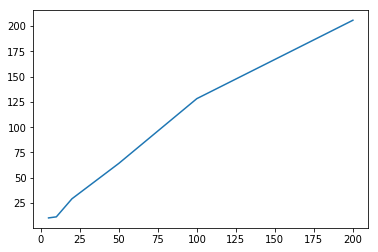

In [28]:
plt.plot(t.n, t.count_time)

In [29]:
sample_sizes = [5,10,20,50,100,200]
for n in sample_sizes:
    print('counting {} samples'.format(n))
    count_time, results = word_count_pandas_sample(n, track=False)
    timing.append({'n': n, 
                   'count_time' : count_time , 
                   'workers' : 2})

counting 5 samples
counting 10 samples
counting 20 samples
counting 50 samples
counting 100 samples
counting 200 samples


In [30]:
t = pd.DataFrame(timing)

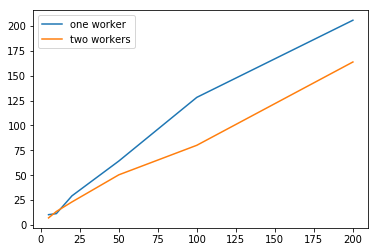

In [31]:
plt.plot(t[t.workers == 1].n, t[t.workers == 1].count_time, label='one worker')
plt.plot(t[t.workers == 2].n, t[t.workers == 2].count_time, label='two workers')
plt.legend()

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
sample

,_id,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,...,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,retweeted,source,text,timestamp_ms,truncated,user
516,5a56c16e36dd5f00015b7601,None,"{'type': 'Point', 'coordinates': [-118.2436849...",Thu Jan 11 01:44:14 +0000 2018,NaN,"{'hashtags': [{'text': 'LosAngeles', 'indices'...",NaN,NaN,0,False,...,NaN,NaN,0,0,False,"<a href=""http://www.tweetmyjobs.com"" rel=""nofo...","Want to work in #LosAngeles, CA? View our late...",1515635054495,False,"{'id': 22454941, 'id_str': '22454941', 'name':..."
17518,5a64f12236dd5f000163d2b5,None,None,Sun Jan 21 19:59:30 +0000 2018,NaN,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,NaN,0,False,...,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/android"" ...",I'm dying. Some of these answers were written...,1516564770515,False,"{'id': 75392015, 'id_str': '75392015', 'name':..."
4862,5a5164c236dd5f0001581efd,None,"{'type': 'Point', 'coordinates': [-122.1802812...",Sun Jan 07 00:07:29 +0000 2018,"[0, 140]","{'hashtags': [{'text': 'job', 'indices': [34, ...",NaN,{'full_text': 'Can you recommend anyone for th...,0,False,...,NaN,NaN,0,0,False,"<a href=""http://www.tweetmyjobs.com"" rel=""nofo...",Can you recommend anyone for this #job? Cupid ...,1515283649641,True,"{'id': 3864064936, 'id_str': '3864064936', 'na..."
19886,5a63e30836dd5f00016346c3,None,None,Sun Jan 21 00:47:04 +0000 2018,NaN,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,{'full_text': 'So we are at Korean bbq they br...,0,False,...,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/iphone"" r...",So we are at Korean bbq they bring us some com...,1516495624419,True,"{'id': 39426309, 'id_str': '39426309', 'name':..."
9554,5a5e16e036dd5f00015fbeab,None,"{'type': 'Point', 'coordinates': [-120.885656,...",Tue Jan 16 15:14:40 +0000 2018,NaN,"{'hashtags': [{'text': 'deepshit', 'indices': ...",NaN,NaN,0,False,...,NaN,NaN,0,0,False,"<a href=""http://instagram.com"" rel=""nofollow"">...",Morning meditation: fuck the haters. You do yo...,1516115680204,False,"{'id': 16861627, 'id_str': '16861627', 'name':..."
704,5a571f0036dd5f00015bbcc5,None,None,Thu Jan 11 08:23:27 +0000 2018,"[107, 111]","{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,...,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/iphone"" r...",@LAFCWingsofTroy @LAFC3252 @ExpoOriginals @Com...,1515659007924,False,"{'id': 54113773, 'id_str': '54113773', 'name':..."
1164,5a75ed5015ba4c0001549957,None,None,Sat Feb 03 17:11:44 +0000 2018,"[0, 12]","{'hashtags': [], 'urls': [{'url': 'https://t.c...",NaN,NaN,0,False,...,9.597347e+17,959734687483727873,0,0,False,"<a href=""http://twitter.com/download/iphone"" r...",Really now 🤔 https://t.co/JQe2vTcWYw,1517677904478,False,"{'id': 38462365, 'id_str': '38462365', 'name':..."
8084,5a57334b36dd5f00015bc39a,None,None,Thu Jan 11 09:50:02 +0000 2018,"[14, 49]","{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,...,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/iphone"" r...",@FatVictoriaa Aw why you gotta do me like that 🤕😂,1515664202897,False,"{'id': 1283736343, 'id_str': '1283736343', 'na..."
9582,5a7cce0f15ba4c000158ef8e,None,None,Thu Feb 08 22:24:14 +0000 2018,NaN,"{'hashtags': [{'text': 'LIVE', 'indices': [0, ...",NaN,{'full_text': '#LIVE 🔴 Road To 4K Subs! Fortni...,0,False,...,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/iphone"" r...",#LIVE 🔴 Road To 4K Subs! Fortnite Battle Royal...,1518128654943,True,"{'id': 32120114, 'id_str': '32120114', 'name':..."
13360,5a7cde4f15ba4c000158fb6e,None,None,Thu Feb 08 23:33:35 +0000 2018,NaN,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,NaN,0,False,...,NaN,NaN,0,0,False,"<a href=""http://twitter.com"" rel=""nofollow"">Ge...",TEST_GEO_Hierarchy: 538898bb-d9d2-46dc-8f4f-df...,1518132815710,False,"{'id': 758415480881164288, 'id_str': '75841548..."


In [34]:
sample = twentyktweets.sample(200)

In [35]:
cv = CountVectorizer().fit(sample)

In [36]:
cv.transform(sample)

<35x35 sparse matrix of type '<class 'numpy.int64'>'
	with 35 stored elements in Compressed Sparse Row format>